In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mod.logs import Logger

# Database access
from mod.dao import MyConn, SqlStatement
from data_lake import PT_TABLE, OP_TABLE, DX_TABLE, DATE_TABLE

# Data cleaning reproduction
from mod.clean.pca import check_series_num, prep_pca, reduce_dim

# Data distance reproduction
from mod.distance.sbd import shape_based_distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# MCRF and prediction reproduction
from mod.prediction import week_prediction

import sys
import copy

In [2]:
# Check the versions of python
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.10.0 (default, Sep 17 2023, 19:13:35) [Clang 14.0.3 (clang-1403.0.22.14.1)]
Version info.
sys.version_info(major=3, minor=10, micro=0, releaselevel='final', serial=0)


# 1. Analysis

## (1) Data Cleaning

### I. 종속변수
종속변수는 병동 카트장 숑량 데이터 사용.

연구자가 (데이터 전처리 과정을 통해서 이미 56개의 분류를 끝나놓은 상태)

`remove_ts_duplicates`를 이용해서 중복 주문 전부 삭제하고 56개의 물품 코드를 기준으로 시계열 생성. (56개)

In [3]:
# Funtion that remove duplicates with specific columns as key
def remove_ts_duplicates(data: pd.DataFrame):
    # Drop if no status
    data = data.dropna(subset=['진행상태'])
    
    # Sort by date (출고일) ensure them in correct order (to get last duplicate)
    data = data.sort_values(by='출고일')

    # Find the index of 3 values "정수수량", "실사수량", "출고수량",
    col = data.columns.to_list()
    dup_col_idx = [col.index("정수수량"), col.index("실사수량"), col.index("출고수량"), col.index("출고요일")]
    
    # Remove `consecutive` duplicates based on dup_keys.
    data_np = data.to_numpy()
    
    # Start with first row included
    nodup_data = list()

    previous_row = None

    for i in range(len(data_np)):
        current_row = data_np[i, dup_col_idx]
        
        if previous_row is None:
            # Add the first line to previous row
            previous_row = current_row
            continue

        if not all(previous_row == current_row):
            # Not duplicate
            nodup_data.append(data_np[i-1])

            # Rewrite previous row
            previous_row = current_row
        else:
            continue

    # Clean up the rest
    if previous_row is not None:
        nodup_data.append(data_np[len(data_np)-1])

    nodup_df = pd.DataFrame(nodup_data, columns=data.columns)
    
    return nodup_df


In [4]:
# TODO: Get it from database
use_df = pd.read_csv("./asset/CART_USE_12_20220804.csv")

# Group by using 물품코드. 
grouped = use_df.groupby('물품코드')

# The researcher has already outlined the usage data. (56)
predefined_result = {
    "521000597", "526615461", "526736132", "521013385", "521081445", "521054730", "526904770",
    "526900760", "526526008", "526959922", "526935077", "526700004", "526720080", "521013370",
    "526800138", "526900691", "526901050", "521086112", "526715420", "526910042", "526936150",
    "528584740", "528806750", "526903484", "526903480", "526977253", "526977254", "521577014",
    "521577015", "526500005", "526500011", "526500025", "521000637", "526978752", "524406743",
    "526674325", "521000646", "521000647", "521086099", "521086067", "526900554", "526715426",
    "526914319", "521127897", "543050111", "526910043", "526910045", "526910044", "526526024",
    "526930650", "526900689", "526900690", "526914317", "528800074", "526900302", "543040200",
}

# Define data
essential_column = ['출고수량']
dfs = []

processed = 0
for name, group in grouped:
    if str(name) not in predefined_result:
        continue

    processed += 1
    print(str(name), f"being processed. {processed}/{len(predefined_result)}")

    # Delete consecutive duplicate value
    nodup_group = remove_ts_duplicates(group)

    # Re-index using `출고일`
    nodup_group.index = nodup_group['출고일']
    nodup_group = nodup_group[essential_column]
    nodup_group.columns = [name]
    df = nodup_group[~nodup_group.index.duplicated(keep='last')]

    dfs.append(df)
    
# Concat to y
y = pd.concat(dfs, axis=1)
y = y.sort_index()


521000597 being processed. 1/56
521000637 being processed. 2/56
521000646 being processed. 3/56
521000647 being processed. 4/56
521013370 being processed. 5/56
521013385 being processed. 6/56
521054730 being processed. 7/56
521081445 being processed. 8/56
521086067 being processed. 9/56
521086099 being processed. 10/56
521086112 being processed. 11/56
521127897 being processed. 12/56
521577014 being processed. 13/56
521577015 being processed. 14/56
524406743 being processed. 15/56
526500005 being processed. 16/56
526500011 being processed. 17/56
526500025 being processed. 18/56
526526008 being processed. 19/56
526526024 being processed. 20/56
526615461 being processed. 21/56
526674325 being processed. 22/56
526700004 being processed. 23/56
526715420 being processed. 24/56
526715426 being processed. 25/56
526720080 being processed. 26/56
526736132 being processed. 27/56
526800138 being processed. 28/56
526900302 being processed. 29/56
526900554 being processed. 30/56
526900689 being pro

### II. 외생변수 (DX, OP, PT)

In [5]:
# Prepare modules
l = Logger()
conn = MyConn("127.0.0.1", "hecon", l, False)
builder = SqlStatement()

In [6]:
# Load data from database
pt = conn.wrap(builder.read_data, table=PT_TABLE)
op = conn.wrap(builder.read_data, table=OP_TABLE)
dx = conn.wrap(builder.read_data, table=DX_TABLE)


        select * from hecon.pt_dl
        

        select * from hecon.op_dl
        

        select * from hecon.dx_dl
        


### i. Regarding Zero Inflation
|	| 0개수 | 전체 개수 | 0 비율 | 연구자 자료 |
|---|------|--------|----|-----------|
|OP | 7095 | 10206 | 0.6952 | 약 70% |
|DX | 7467 | 10935 | 0.682853224 | 약 69% |

### ii. Regarding Principal Component Analysis

In [7]:
# Principal Component Analysis

# Reshape data by (TimeFrame * Series) Matrices using `pivot`
ptdf = pd.DataFrame(pt)
opdf = pd.DataFrame(op)
dxdf = pd.DataFrame(dx)

ptdf = ptdf.pivot(index=1, columns=0, values=2)
opdf = opdf.pivot(index=1, columns=0, values=2)
dxdf = dxdf.pivot(index=1, columns=0, values=2)

# Without date column
print("PT time series:", check_series_num(ptdf))
print("OP time series:", check_series_num(opdf))
print("DX time series:", check_series_num(dxdf))
print("\n")


PT time series: 15
OP time series: 42
DX time series: 45




* OP와 DX 데이터 프레임에서 시계열 개수는각각 42개, 45개로 파워포인트 5페이지의 "42개 변수", "45개 변수"와 일치.
* PT를 제외하고, OP + DX 데이터 프레임을 합한 (243 * 87) 매트릭스에서 PCA를 통해 차원 축소. 목표 (87개의 시계열 -> 19개의 시계열)

In [8]:
# Prep PCA Data. - Use only 215 data points to prevent data leakage
data = prep_pca([opdf, dxdf], 215)
print("OP & DX data merged by dates. Shape:", data.shape)

# Perform PCA with Standardization as default
# `result` has 
#   1. "pca_model":     Fitted `pca` model
#   2. "scaler":        Fitted `scaler` model
#   3. "pc":            Principal components
#   4. "explained_var": Explained variance
result = reduce_dim([opdf, dxdf], 19, True, 215, False)

OP & DX data merged by dates. Shape: (215, 87)


Result of the PCA shows that
* The total explained variance for selected 19 components are indeed account up to 75% of the total variance. 

### iii. Add datetime information

In [9]:
# Call datetime data from sql
date = conn.wrap(builder.read_data, table=DATE_TABLE)
date = pd.DataFrame(date)
date = date.set_index(0)

# Set name of columns
date.columns = ["month", "day", "year", "weekday"]

# Only use 3 columns
date = date[["month", "day", "weekday"]]

# Sort in timely order
date = date.sort_index()


        select * from hecon.dt
        


### iv. Y 와 X 만들기
y: 1에 정의된 56개의 물품코드 시계열

X: 외생변수(과거 7일간) + Datetime information(3개) + PCA(19개) + PT(15개)

In [10]:
# Add datetime information to Principal components
pc_wdt = result['pc'].join(date, how='inner')
pc_wdt.head(5)

# Add PT data to Principal (components + date).

ptdf = pd.DataFrame(pt)
ptdf = ptdf.pivot(index=1, columns=0, values=2)
x = pc_wdt.join(ptdf)

# Fix exogenous variable column name here.
# Use copy to create a completely separate entity
exogenous_column = copy.deepcopy(x.columns)

# Add Past 7 days data
past = 7
past_dfs = list()

for i in range(past):
    df = y.shift(i+1)
    df.columns = [f"{x}_ar{i+1}" for x in y.columns]
    past_dfs.append(df)

y_ar = pd.concat(past_dfs, axis=1)

# Denote it as x.
x = pd.concat([x, y_ar], axis=1)
x = x.astype(float)  # ensures calculatable data type
xnp = x.to_numpy()
print("(Principal components + Datetime + 물류_PT) data's shape", x.shape)


(Principal components + Datetime + 물류_PT) data's shape (243, 429)


In [11]:
# Fix (re-index) y dataframe (because it's sparse)
# using `x` dataframe index
y = y.reindex(x.index)

## (2) Data Clustering

y에서 정의된 물품 코드별 시계열을 clustering. 

In [12]:
# Distance wrapper
def wrap_shape_based_distance(x_array: list | np.ndarray, y_array: list | np.ndarray):
    return shape_based_distance(x_array, y_array, True, True, True)

In [13]:
# Use 1~215 data to prevent data leakage
# (Exempting test data from the scope)
train_data_len = 215

ynp = y.fillna(0).iloc[:train_data_len].to_numpy()

# Calculate, and generate distance matrix of (n, n) dubbed `dist_matrix`
# where n is the number of time series.
n_series = ynp.shape[1]
dist_matrix = np.zeros((n_series, n_series))

for i in range(n_series):
    for j in range(n_series):
        try:
            dist_matrix[i][j] = wrap_shape_based_distance(ynp[:, i], ynp[:, j])["dist"]
            if dist_matrix[i][j] != dist_matrix[i][j]:
                print(i, j, "nan")
        except TypeError as e:
            print(e)
            print("error occurred on", i, j)
            raise e

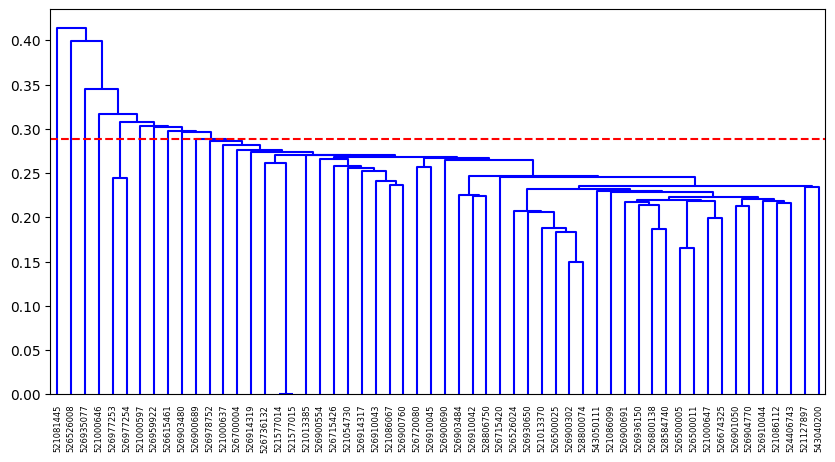

In [14]:
# Perform heirarchical clustering
linked = linkage(dist_matrix, method='single')

# Draw the figure
# Define the threshold and display it on the graph
THRESHOLD = 0.289

plt.figure(figsize=(10, 5))
dendrogram(linked, labels=y.columns, link_color_func=lambda _: 'blue')
plt.axhline(y=THRESHOLD, color = 'r', linestyle='--')
plt.show()

<b>연구자의 ppt와 다른 결과가 나옴. </b>

Possible deviation 이유

1. 데이터 중복 처리 로직
2. 재고 데이터에서 현재 (출고 수량) 사용 중.
  - ppt, 논문에는 별 언급 없음. 이 시계열 데이터가 맞는지 확인
3. 거리 계산 함수의 차이 (가능성 낮음. R 코드 그대로 chat-gpt와 함께 번역)

In [15]:
# Cluster series. Record them on `cluster_map`
clusters = fcluster(linked, THRESHOLD, criterion='distance')
cluster_map = dict()

for i in range(1, max(clusters)+1):
    print(f"Cluster {i}:", np.array(y.columns)[clusters == i])
    print()

    cluster_map[i] = np.array(y.columns)[clusters == i].tolist()

Cluster 1: [526977253 526977254]

Cluster 2: [521000637 521000647 521013370 521013385 521054730 521086067 521086099
 521086112 521127897 521577014 521577015 524406743 526500005 526500011
 526500025 526526024 526674325 526700004 526715420 526715426 526720080
 526736132 526800138 526900302 526900554 526900690 526900691 526900760
 526901050 526903484 526904770 526910042 526910043 526910044 526910045
 526914317 526914319 526930650 526936150 526978752 528584740 528800074
 528806750 543040200 543050111]

Cluster 3: [526900689]

Cluster 4: [526903480]

Cluster 5: [526615461]

Cluster 6: [526959922]

Cluster 7: [521000597]

Cluster 8: [521000646]

Cluster 9: [526935077]

Cluster 10: [526526008]

Cluster 11: [521081445]



## (3). Prediction

분류된 각 클러스터마다 Multivariate Count Random Forest 실행

### MCRF Model: Multivariate Count Random Forest

As for `multivariate`, we observed multiple values for our dependent variables. We don't want to fit random forest model to each time series column, therefore we use Multivariate.

$$\{y_{1,t}, y_{2,t}, y_{3,t}, ..., y_{k,t}\} = \{y_{1,t-7}, y_{2,t-7}, y_{3,t-7}, ..., y_{k,t-7}, x_{1,t}, x_{2,t}, ... x_{l,t}\}$$  

* My guess: `y`s are the usage of hospital supplies, `x`s includes other things from dataset PT, OP and DX

As for `Count`, because dataset uses small amount of occurrance, distribution can be more accurately depicted when we use poisson distribution. 
* Using poisson distribution part is in `scikit-learn`'s `RandomForestRegressor` package.([scikit-learn's random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html))

<b>Setup</b>
* Training data: 181 (6 months)
* Test data: 28 (4 weeks)
* Rolling window update (1 week)
* Use of 500 trees

In [22]:
def create_ar_column_name(names: list):
    ars = 7
    col_names = list()
    for n in names:
        for i in range(ars):
            col_names.append(f"{n}_ar{i+1}")
    return col_names


def predict_by_cluster(cluster_key: int, predicting_spot: int):
    # Dependent variable
    rf_y = y[cluster_map[cluster_key]].fillna(0).to_numpy()

    # Independent variables
    ar_cols = create_ar_column_name(cluster_map[i])
    target_indep = [*ar_cols, *exogenous_column]
    rf_x = x[target_indep].fillna(0).to_numpy()

    # Split them into train and testing set
    train_period = 181
    test_period = 28

    rf_y_train, rf_x_train = (
        rf_y[(predicting_spot-train_period):predicting_spot], 
        rf_x[(predicting_spot-train_period):predicting_spot]
    )
    rf_y_test, rf_x_test = (
        rf_y[predicting_spot:(predicting_spot+test_period)], 
        rf_x[predicting_spot:(predicting_spot+test_period)])

    print(f"At index {predicting_spot}")
    print("y train shape:", rf_y_train.shape)
    print("x train shape:", rf_x_train.shape)
    print("y test shape:", rf_y_test.shape)
    print("x test shape:", rf_x_test.shape)

    week_prediction(rf_x_train, rf_y_train, rf_x_test)

In [23]:
# Create prediction models by cluster
# 나중에 `cluter_key`의 숫자를 바꿔서 클러스터 별 model fitting 가능
model_1_pred = predict_by_cluster(cluster_key=1, predicting_spot=215)


At index 215
y train shape: (181, 2)
x train shape: (181, 44)
y test shape: (28, 2)
x test shape: (28, 44)
Creating model
Start fitting model
Fitting completed, 1.2893171310424805s
[[0.49332457 0.8606127 ]
 [0.4949926  0.86074501]
 [0.48734348 0.8655758 ]
 [0.53424212 0.99308443]
 [0.45960904 0.82089571]
 [0.46049889 0.86734631]
 [0.49714413 0.8674435 ]
 [0.52887388 0.95746339]
 [0.46987179 0.82386492]
 [0.45327919 0.88487257]
 [0.53269344 0.95817676]
 [0.46725254 0.82373261]
 [0.46676165 0.86834116]
 [0.49575777 0.8752435 ]
 [0.49332457 0.8606127 ]
 [0.4949926  0.86074501]
 [0.48734348 0.8655758 ]
 [0.53424212 0.99308443]
 [0.45960904 0.82089571]
 [0.46049889 0.86734631]
 [0.53269344 0.95817676]
 [0.46725254 0.8250342 ]
 [0.46676165 0.86834116]
 [0.48992443 0.88694412]
 [0.49332457 0.8606127 ]
 [0.4949926  0.86074501]
 [0.48734348 0.8655758 ]
 [0.48872984 0.8577758 ]]


소수점으로 나오는 것을 봐서, 연구자가 사용한 R-code를 참고해야 할 것 같습니다. - Counting value 이니 정수로 나와야 하기 때문

## (4) Ordering

- 주문량 결정을 위해서는 weight가 필요함.
- 연구자는 weight 계산을 위해서, 가격을 z-normalize 후, z-norm 값을 시그모이드 함수에 집어넣음.

현재 가격 정보 제공되지 않았으므로, weight 구할 수 없음.